In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import seaborn as sns

In [4]:
dfi = pd.read_csv('./Data/Weather/city_hour.csv')
dfi

City             Datetime  PM2.5   PM10    NO    NO2    NOx  \
0           Ahmedabad  2015-01-01 01:00:00    NaN    NaN  1.00  40.01  36.37   
1           Ahmedabad  2015-01-01 02:00:00    NaN    NaN  0.02  27.75  19.73   
2           Ahmedabad  2015-01-01 03:00:00    NaN    NaN  0.08  19.32  11.08   
3           Ahmedabad  2015-01-01 04:00:00    NaN    NaN  0.30  16.45   9.20   
4           Ahmedabad  2015-01-01 05:00:00    NaN    NaN  0.12  14.90   7.85   
...               ...                  ...    ...    ...   ...    ...    ...   
707870  Visakhapatnam  2020-06-30 20:00:00   9.50  36.00  2.75  25.57  15.85   
707871  Visakhapatnam  2020-06-30 21:00:00  17.25  49.25  3.62  33.20  20.62   
707872  Visakhapatnam  2020-06-30 22:00:00  36.00  71.00  2.20  30.80  18.20   
707873  Visakhapatnam  2020-06-30 23:00:00  15.75  63.00  1.02  28.90  16.00   
707874  Visakhapatnam  2020-07-01 00:00:00  15.00  66.00  0.40  26.85  14.05   

         NH3    CO     SO2      O3  Benzene  Toluene  Xylene   AQI  \
0        NaN  1.00  122.07     NaN      0.0      0.0     0.0   NaN   
1        NaN  0.02   85.90     NaN      0.0      0.0     0.0   NaN   
2        NaN  0.08   52.83     NaN      0.0      0.0     0.0   NaN   
3        NaN  0.30   39.53  153.58      0.0      0.0     0.0   NaN   
4        NaN  0.12   32.63     NaN      0.0      0.0     0.0   NaN   
...      ...   ...     ...     ...      ...      ...     ...   ...   
707870  4.57  0.62     NaN   27.75      NaN      NaN     NaN  51.0   
707871  3.78  0.76    2.02   25.58      NaN      NaN     NaN  51.0   
707872  3.67  0.58    1.77   26.15      NaN      NaN     NaN  50.0   
707873  3.80  0.49    0.75   15.82      NaN      NaN     NaN  50.0   
707874  5.20  0.59    2.10   17.05      NaN      NaN     NaN  50.0   

          AQI_Bucket  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
707870  Satisfactory  
707871  Satisfactory  
707872          Good  
707873          Good  
707874          Good  

[707875 rows x 16 columns]

In [5]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [6]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df = df.set_index('Datetime')
df

PM2.5    PM10     CO    AQI
Datetime                                         
2015-01-01 16:00:00  211.51  340.66  15.24  456.0
2015-01-01 17:00:00  191.12  257.40  13.11  450.0
2015-01-01 18:00:00  218.44  351.01  18.35  446.0
2015-01-01 19:00:00  296.80  600.95  16.67  475.0
2015-01-01 20:00:00  336.43  714.63  12.17  480.0
...                     ...     ...    ...    ...
2015-12-31 19:00:00  142.61  359.15   2.64  412.0
2015-12-31 20:00:00  201.88  464.06   3.79  415.0
2015-12-31 21:00:00  272.73  535.32   2.89  432.0
2015-12-31 22:00:00  271.46  518.95   3.02  433.0
2015-12-31 23:00:00  292.16  552.16   3.16  435.0

[4949 rows x 4 columns]

# **STATISTICAL TESTS**

<Axes: xlabel='Datetime'>

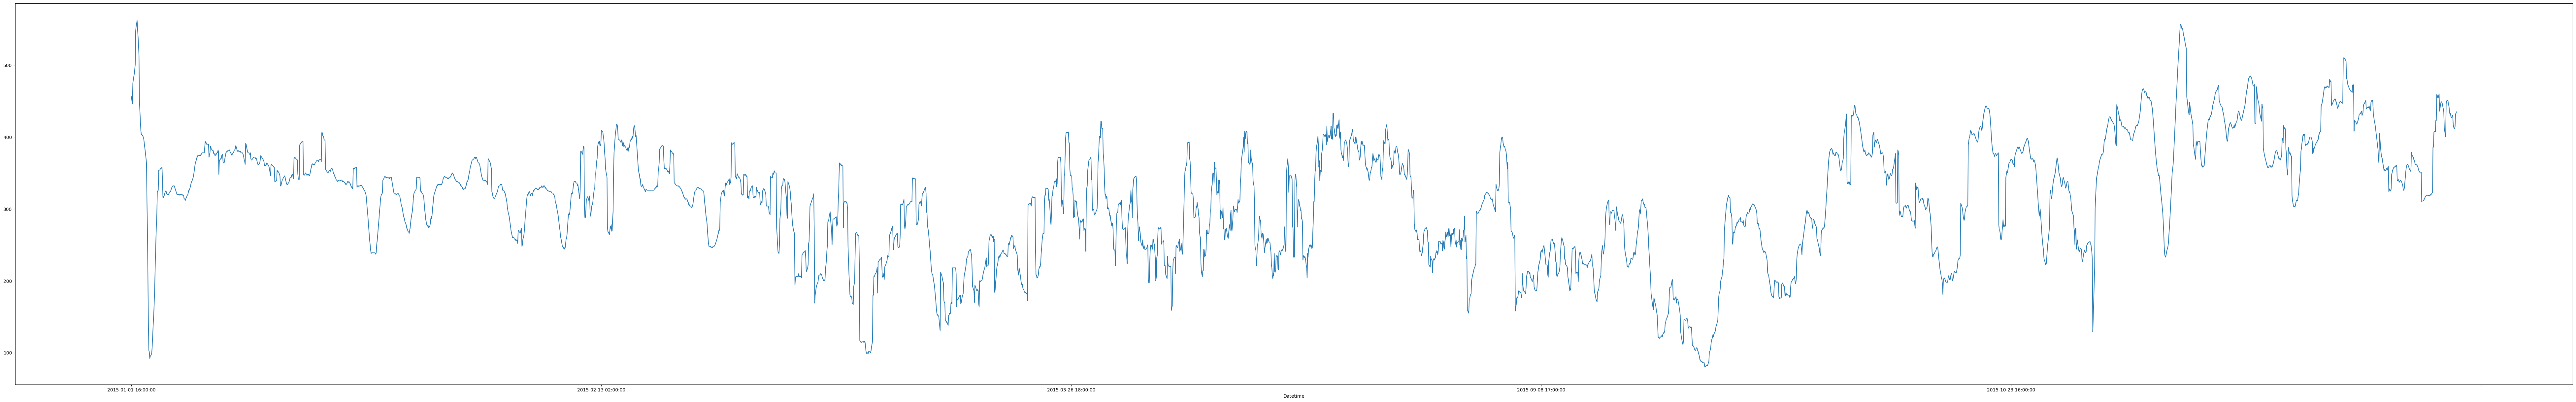

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 100, 15
df['AQI'].plot()

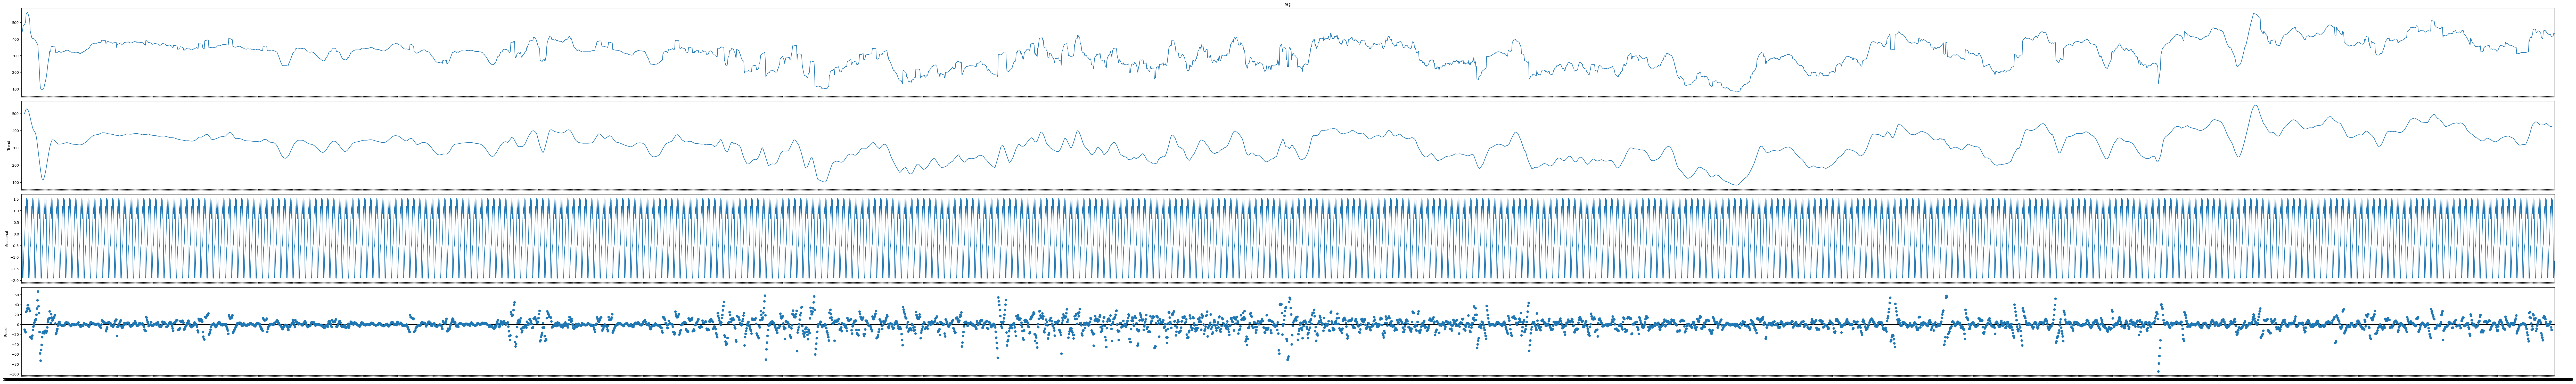

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['AQI'], model='additive', period=12) 
result.plot()
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [10]:
adf_test(df['AQI'])

ADF Test Statistic : -6.332103803450005
p-value : 2.889435011468367e-08
#Lags Used : 16
Number of Observations : 4932
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Figure size 1200x600 with 0 Axes>

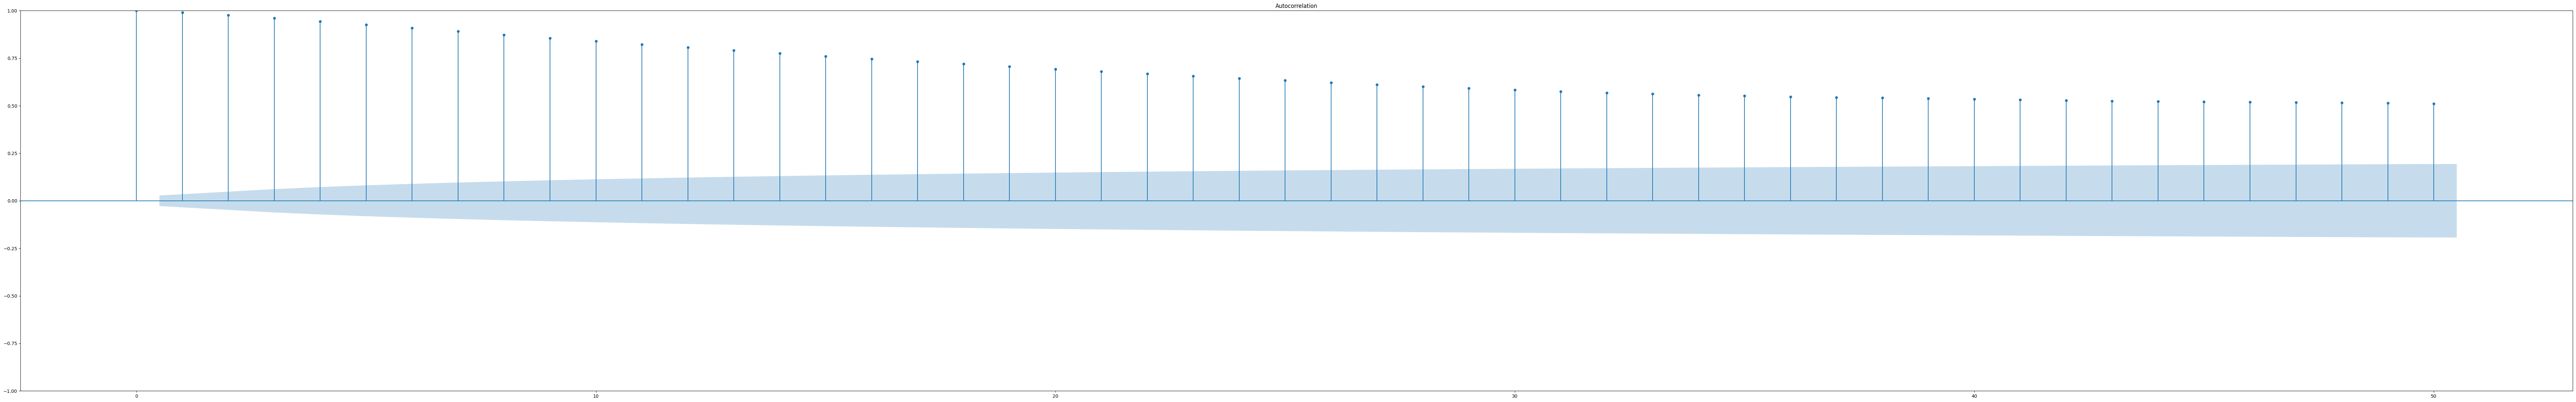

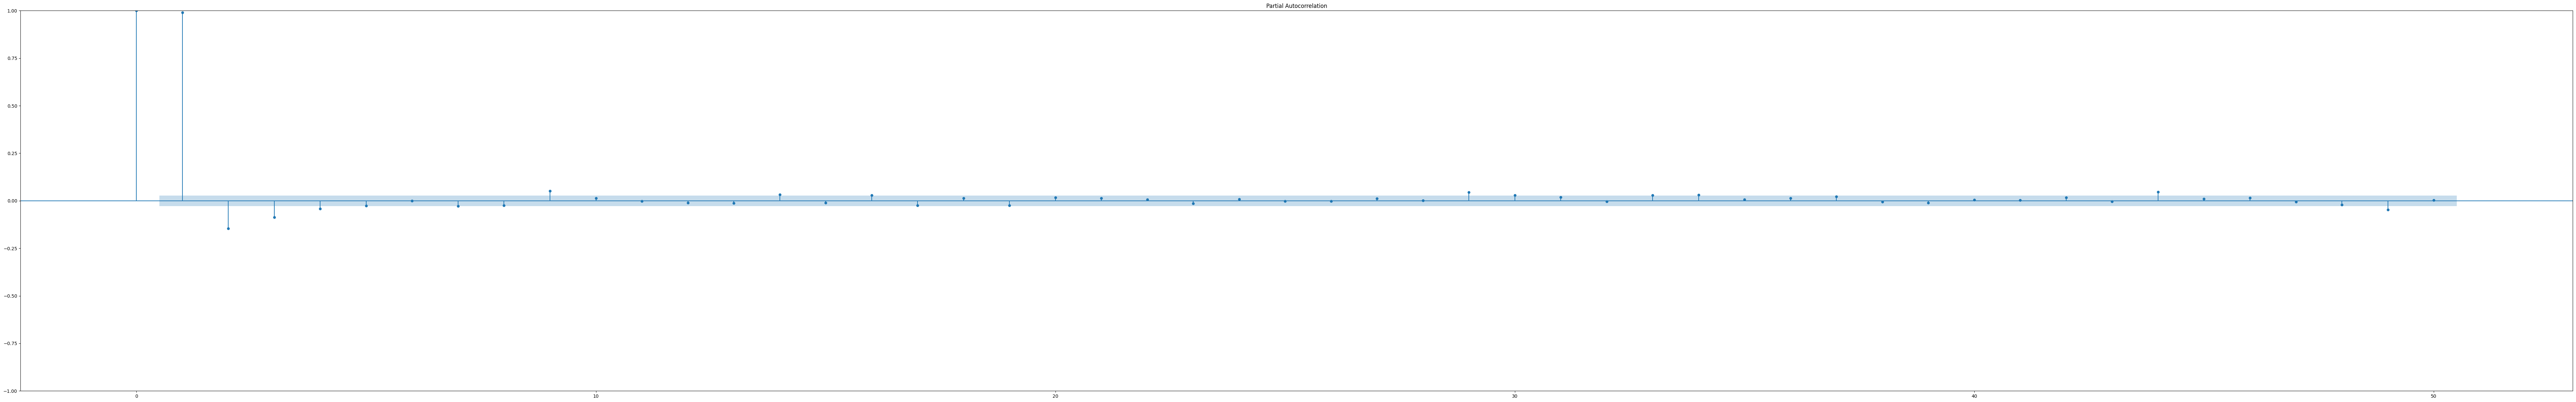

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['AQI'], lags=50) # p = 
plot_pacf(df['AQI'], lags=50) # q = 
plt.show()

# **ARIMA MODEL**

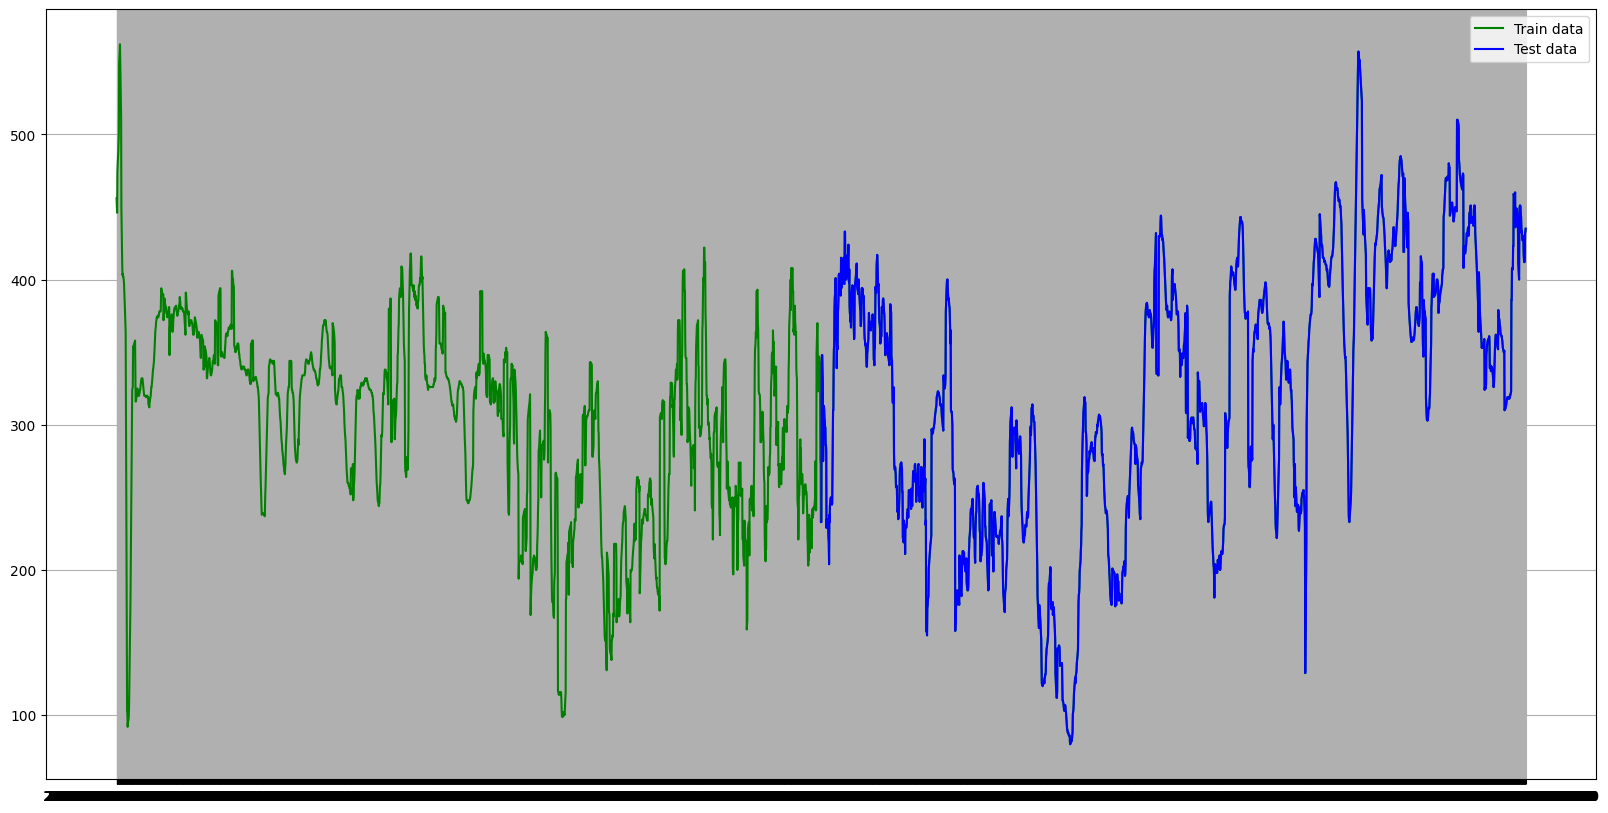

In [12]:
train_data, test_data = df[:int(len(df)*0.5)], df[int(len(df)*0.5):]
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df['AQI'], 'green', label='Train data')
plt.plot(test_data['AQI'], 'blue', label='Test data')
plt.legend()

In [13]:
"""import itertools
import warnings
warnings.filterwarnings("ignore")
q_arima = range(0, 12)
d_arima = range(0,3)
p_arima = range(0, 12)
AIC_arima = []
ARIMAX_model = []
pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]

for pdq in pdqs:
    try:
        mod = ARIMA(train_data['AQI'],order=pdq)

        results = mod.fit()
        print('ARIMAX{} - AIC:{}'.format(pdq, results.aic), end='\r')
        AIC_arima.append(results.aic)
        ARIMAX_model.append([(1,1,0), pdq])
    except:
            continue
    
print('The smallest AIC is {} for model ARIMAX{}'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))
order_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]"""

'import itertools\nimport warnings\nwarnings.filterwarnings("ignore")\nq_arima = range(0, 12)\nd_arima = range(0,3)\np_arima = range(0, 12)\nAIC_arima = []\nARIMAX_model = []\npdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p_arima, d_arima, q_arima))]\n\nfor pdq in pdqs:\n    try:\n        mod = ARIMA(train_data[\'AQI\'],order=pdq)\n\n        results = mod.fit()\n        print(\'ARIMAX{} - AIC:{}\'.format(pdq, results.aic), end=\'\r\')\n        AIC_arima.append(results.aic)\n        ARIMAX_model.append([(1,1,0), pdq])\n    except:\n            continue\n    \nprint(\'The smallest AIC is {} for model ARIMAX{}\'.format(min(AIC_arima),ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]))\norder_a = ARIMAX_model[AIC_arima.index(min(AIC_arima))][1]'

In [14]:
#The smallest AIC is 19135.186339359283 for model ARIMAX(10, 1, 11)
order_a = (10,1,11)

In [15]:
train, test = train_data['AQI'], test_data['AQI']

model = ARIMA(train, order=order_a)
result = model.fit()

forecast_a = result.get_forecast(steps=len(test))
predicted_mean = forecast_a.predicted_mean

mse = mean_squared_error(test, predicted_mean)
rmse = math.sqrt(mse)
print(f'Mean Squared Error: {mse}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Mean Squared Error: 10818.895886134178


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
print(mse)
print(rmse)

10818.895886134178
104.01392159770815


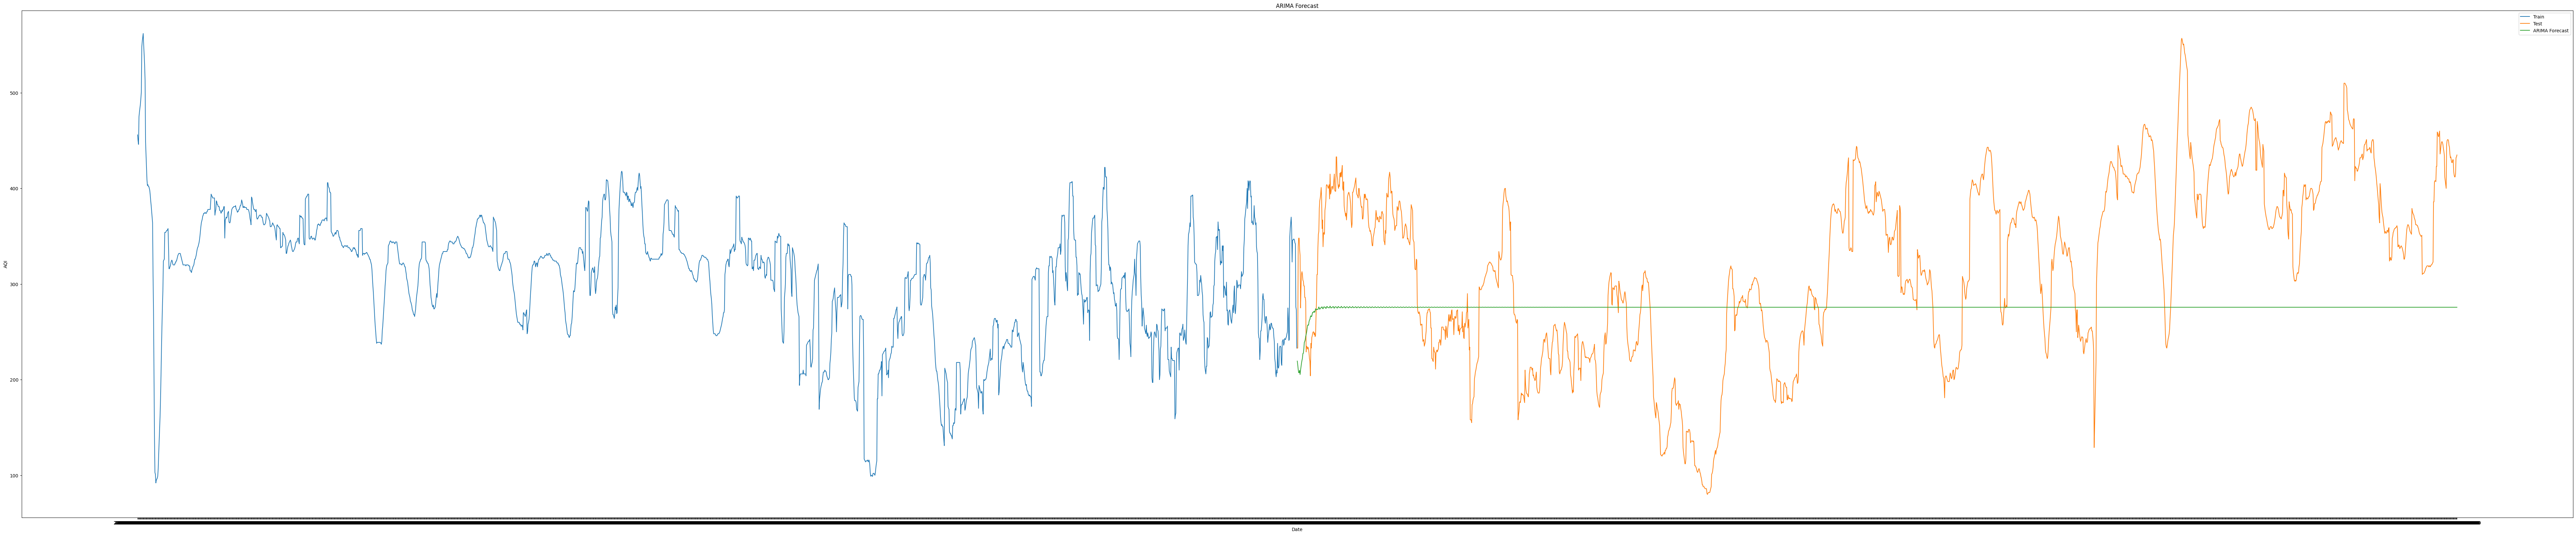

In [17]:
plt.figure(figsize=(100, 20))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predicted_mean, label='ARIMA Forecast')
# plt.fill_between(forecast.conf_int().index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# **QLSTM MODEL**

In [18]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted','residuals'])
ARIMA_Result['raw'] = test_data['AQI'].copy()
ARIMA_Result['predicted'] = predicted_mean.to_numpy()
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
std_residuals = ARIMA_Result['residuals'].std()
ARIMA_Result['std_residuals'] = ARIMA_Result['residuals'] / std_residuals
ARIMA_Result['nxt_target'] = ARIMA_Result['residuals'].shift(-1)
ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
ARIMA_Result

/tmp/ipykernel_1439/3125680185.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]
/tmp/ipykernel_1439/3125680185.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ARIMA_Result['nxt_target'][len(ARIMA_Result)-1] = ARIMA_Result['nxt_target'][len(ARIMA_Result)-2]


raw   predicted   residuals  std_residuals  nxt_target
Datetime                                                                     
2015-04-16 04:00:00  233.0  219.468364   13.531636       0.145012   17.547506
2015-04-16 05:00:00  233.0  215.452494   17.547506       0.188048  128.330271
2015-04-16 06:00:00  339.0  210.669729  128.330271       1.375254  140.741117
2015-04-16 07:00:00  348.0  207.258883  140.741117       1.508255  140.622456
2015-04-16 08:00:00  348.0  207.377544  140.622456       1.506984  126.187753
...                    ...         ...         ...            ...         ...
2015-12-31 19:00:00  412.0  275.721699  136.278301       1.460430  139.278301
2015-12-31 20:00:00  415.0  275.721699  139.278301       1.492579  156.278301
2015-12-31 21:00:00  432.0  275.721699  156.278301       1.674760  157.278301
2015-12-31 22:00:00  433.0  275.721699  157.278301       1.685477  159.278301
2015-12-31 23:00:00  435.0  275.721699  159.278301       1.706910  159.278301

[2475 rows x 5 columns]

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time

In [20]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:]) 
    data = scaler2.fit_transform(data.iloc[:,:1])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [21]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 2
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 1
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [22]:
size = int(len(ARIMA_Result) * 0.5)

train = ARIMA_Result[['residuals','nxt_target']][:size].copy()
test = ARIMA_Result[['residuals','nxt_target']][size:].copy()

In [23]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [24]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [25]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [26]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = QRegressionLSTM(num_sensors=1, hidden_units= 6, n_qubits=1)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 1)


In [27]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)}')

[1/5]  LossQ:212.33561897580512


[2/5]  LossQ:59.457176541152876
[3/5]  LossQ:16.955379663864733
[4/5]  LossQ:14.931079667458107
[5/5]  LossQ:13.978904308809433


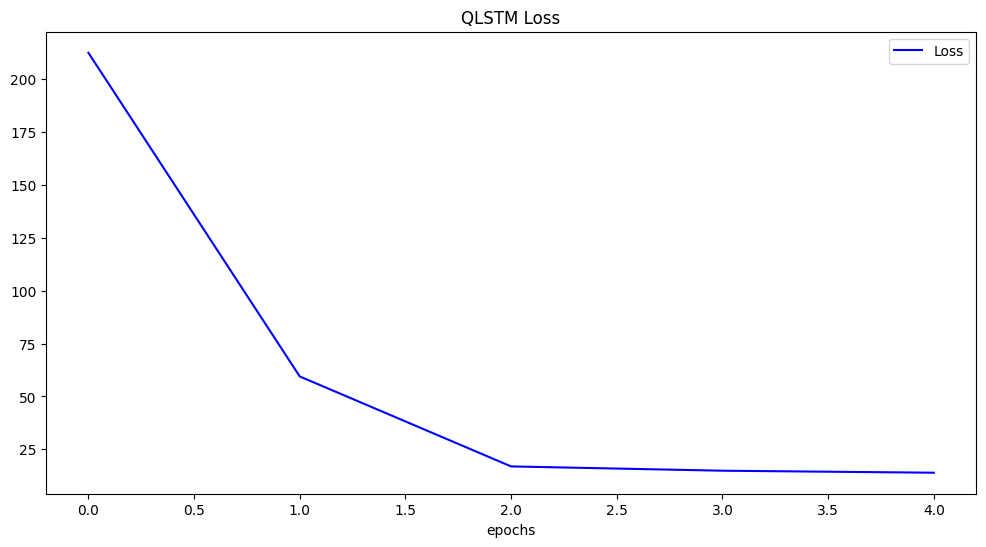

In [28]:
np.savetxt('./SavedModels/Weather/Delhi_AQI/Loss/arima_qlstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [29]:
histQ1 = histQ 

In [30]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)


    return output

In [31]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([1.2234, 1.2028, 1.1400,  ..., 1.5001, 1.5458, 1.2902],
       grad_fn=<ViewBackward0>)


In [32]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)
pred_y_train

tensor([[1.2234],
        [1.2028],
        [1.1400],
        ...,
        [1.5001],
        [1.5458],
        [1.2902]], grad_fn=<ViewBackward0>)

In [33]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [34]:
np.savetxt('./SavedModels/Weather/Delhi_AQI/Train/arima_qlstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/Delhi_AQI/Test/arima_qlstm.txt',y_test_pred)

Training dataset MSE: 596.3147788765333 RMSE:24.41955730304162


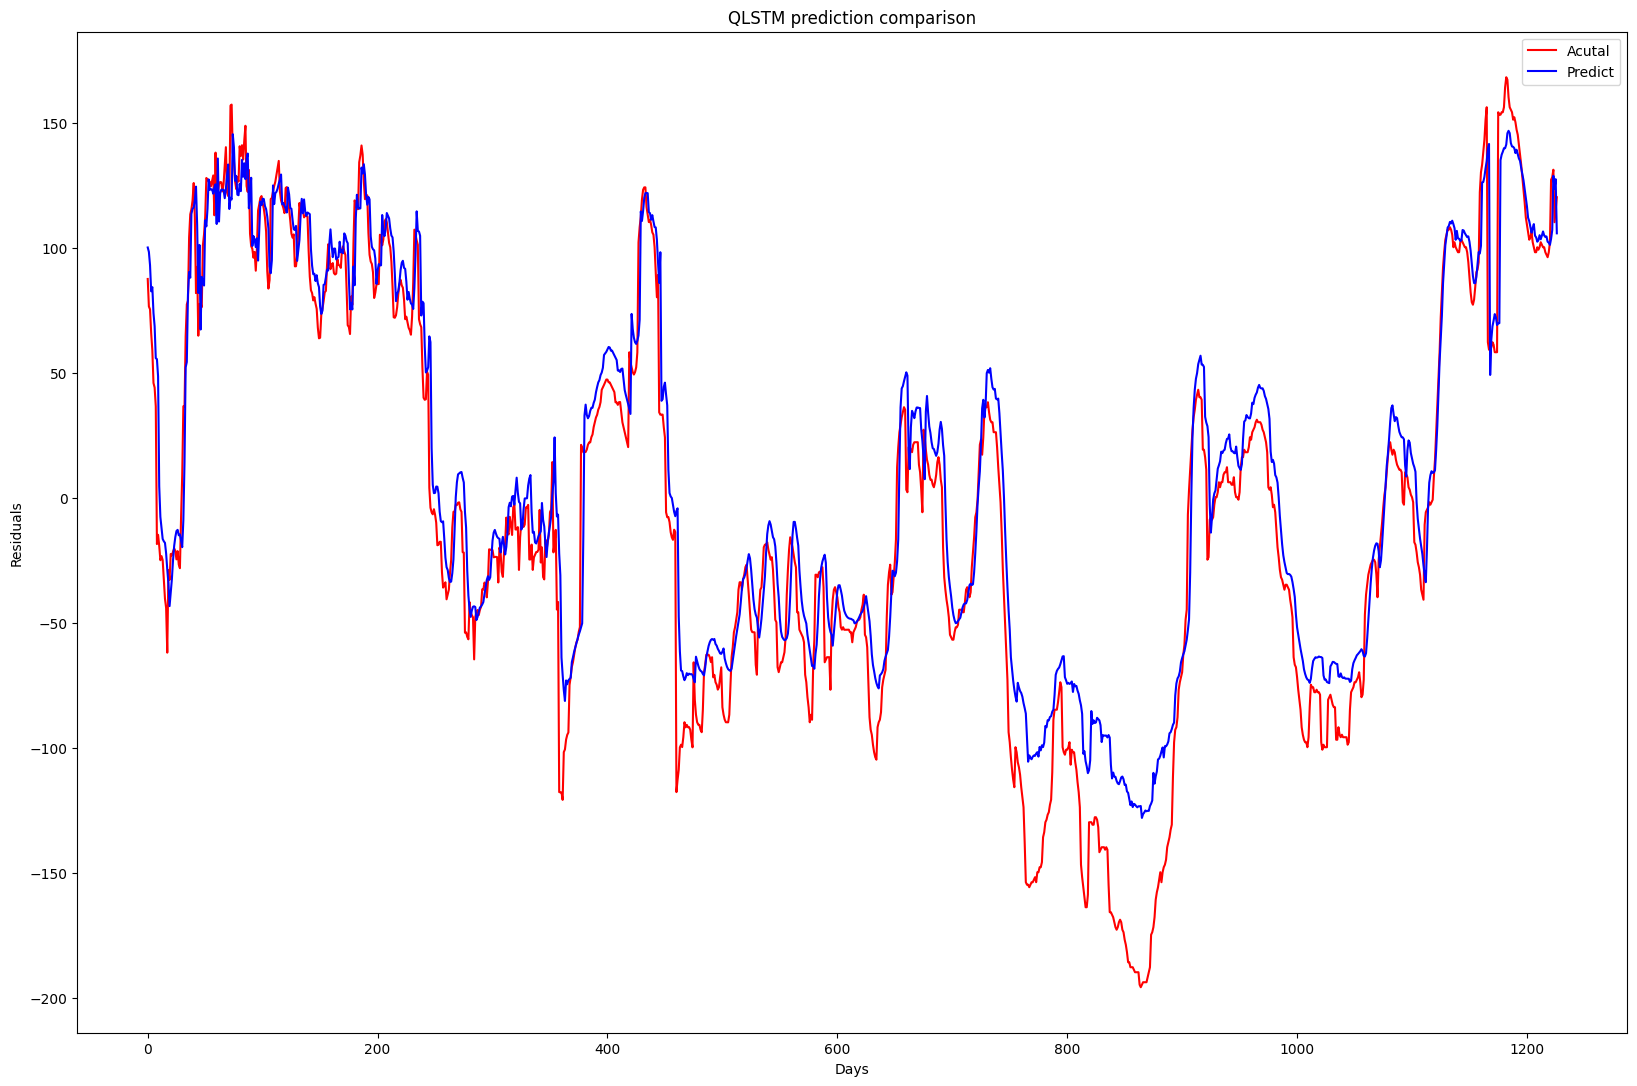

In [35]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('Residuals')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset MSE:641.821416409384 RMSE:25.33419460747438


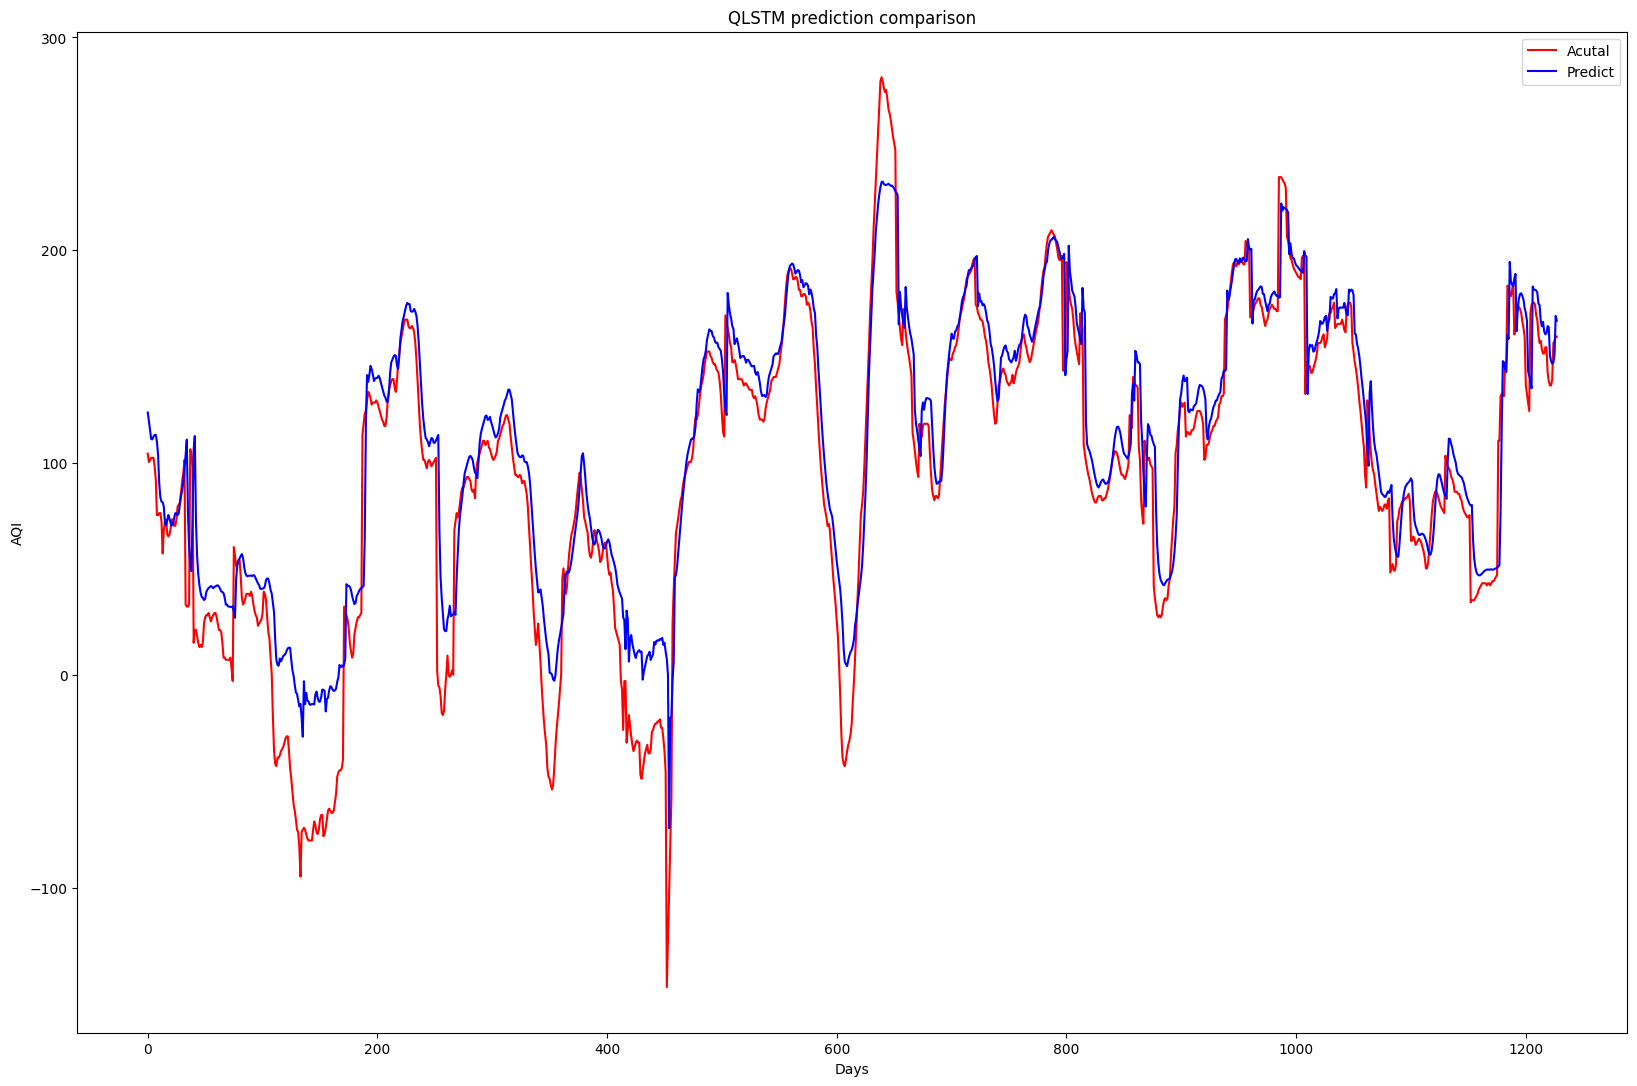

In [36]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE:{MSE} RMSE:{RMSE}')

In [37]:
final_result_qlstm = ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [38]:
frq = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
frq['final'] = final_result_qlstm
frq

predicted    raw       final
Datetime                                          
2015-10-08 18:00:00  275.721324  384.0  399.295520
2015-10-08 19:00:00  275.721431  380.0  395.405093
2015-10-08 20:00:00  275.721800  376.0  391.107817
2015-10-08 21:00:00  275.722065  377.0  386.829968
2015-10-08 22:00:00  275.721965  378.0  386.652072
...                         ...    ...         ...
2015-12-31 19:00:00  275.721699  412.0  422.306889
2015-12-31 20:00:00  275.721699  415.0  422.823902
2015-12-31 21:00:00  275.721699  432.0  426.307530
2015-12-31 22:00:00  275.721699  433.0  444.753590
2015-12-31 23:00:00  275.721699  435.0  442.488545

[1228 rows x 3 columns]

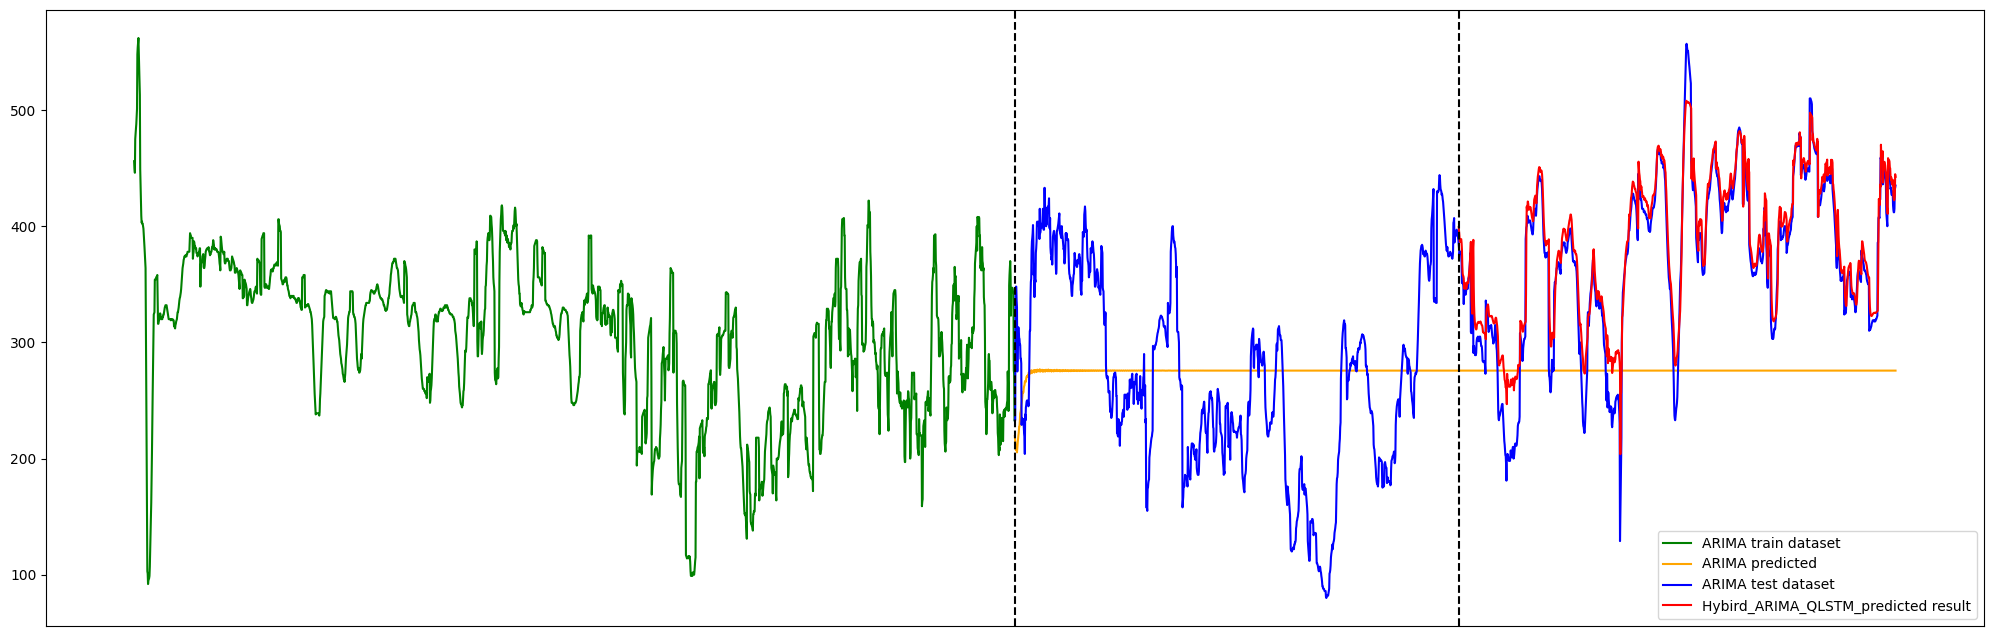

In [39]:
plt.figure(figsize=(25,8))
plt.plot(train_data['AQI'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result', color='red')
plt.axvline(x=len(train_data['AQI']), c='black', linestyle='--')
plt.axvline(x=len(train_data['AQI']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result_qlstm,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result_qlstm, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 521.0807590284991
X_test MAE: 16.28258457151508
X_test RMSE: 22.82719341111603


In [41]:
torch.save(modelQ.state_dict(),'./SavedModels/Weather/Delhi_AQI/AQI/arima_QLSTM__sd')

# **LSTM MODEL**

In [42]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [58]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=1, hidden_units=6)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [59]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:81.37222695326273 
[2/5]  LossQ:19.06063387060931 
[3/5]  LossQ:13.645576931203323 
[4/5]  LossQ:11.62248350745358 
[5/5]  LossQ:10.646447097347846 


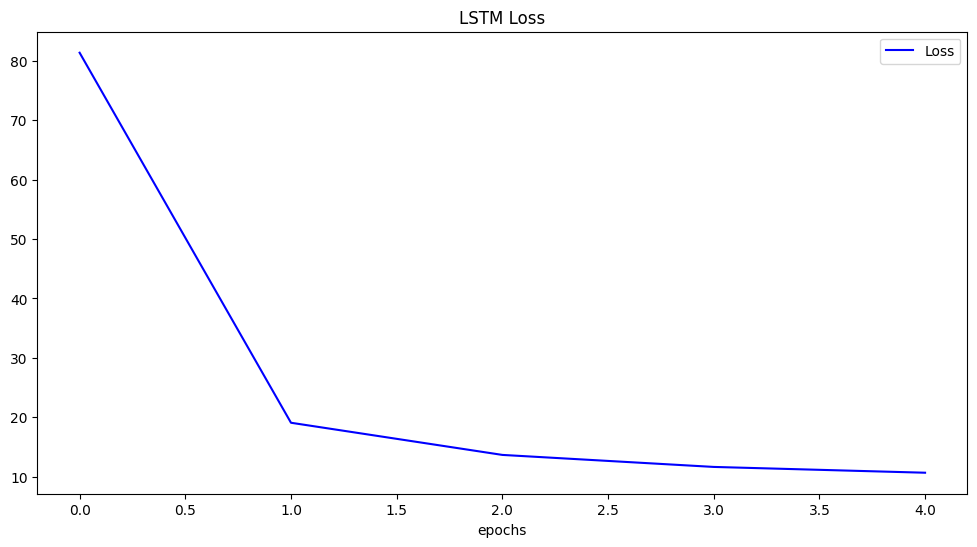

In [60]:
np.savetxt('./SavedModels/Weather/Delhi_AQI/Loss/arima_lstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [61]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)

In [62]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [63]:
np.savetxt('./SavedModels/Weather/Delhi_AQI/Train/arima_lstm.txt',y_train_pred)
np.savetxt('./SavedModels/Weather/Delhi_AQI/Test/arima_lstm.txt',y_test_pred)

Training dataset MSE: 650.4988844551534 RMSE:25.504879620479556


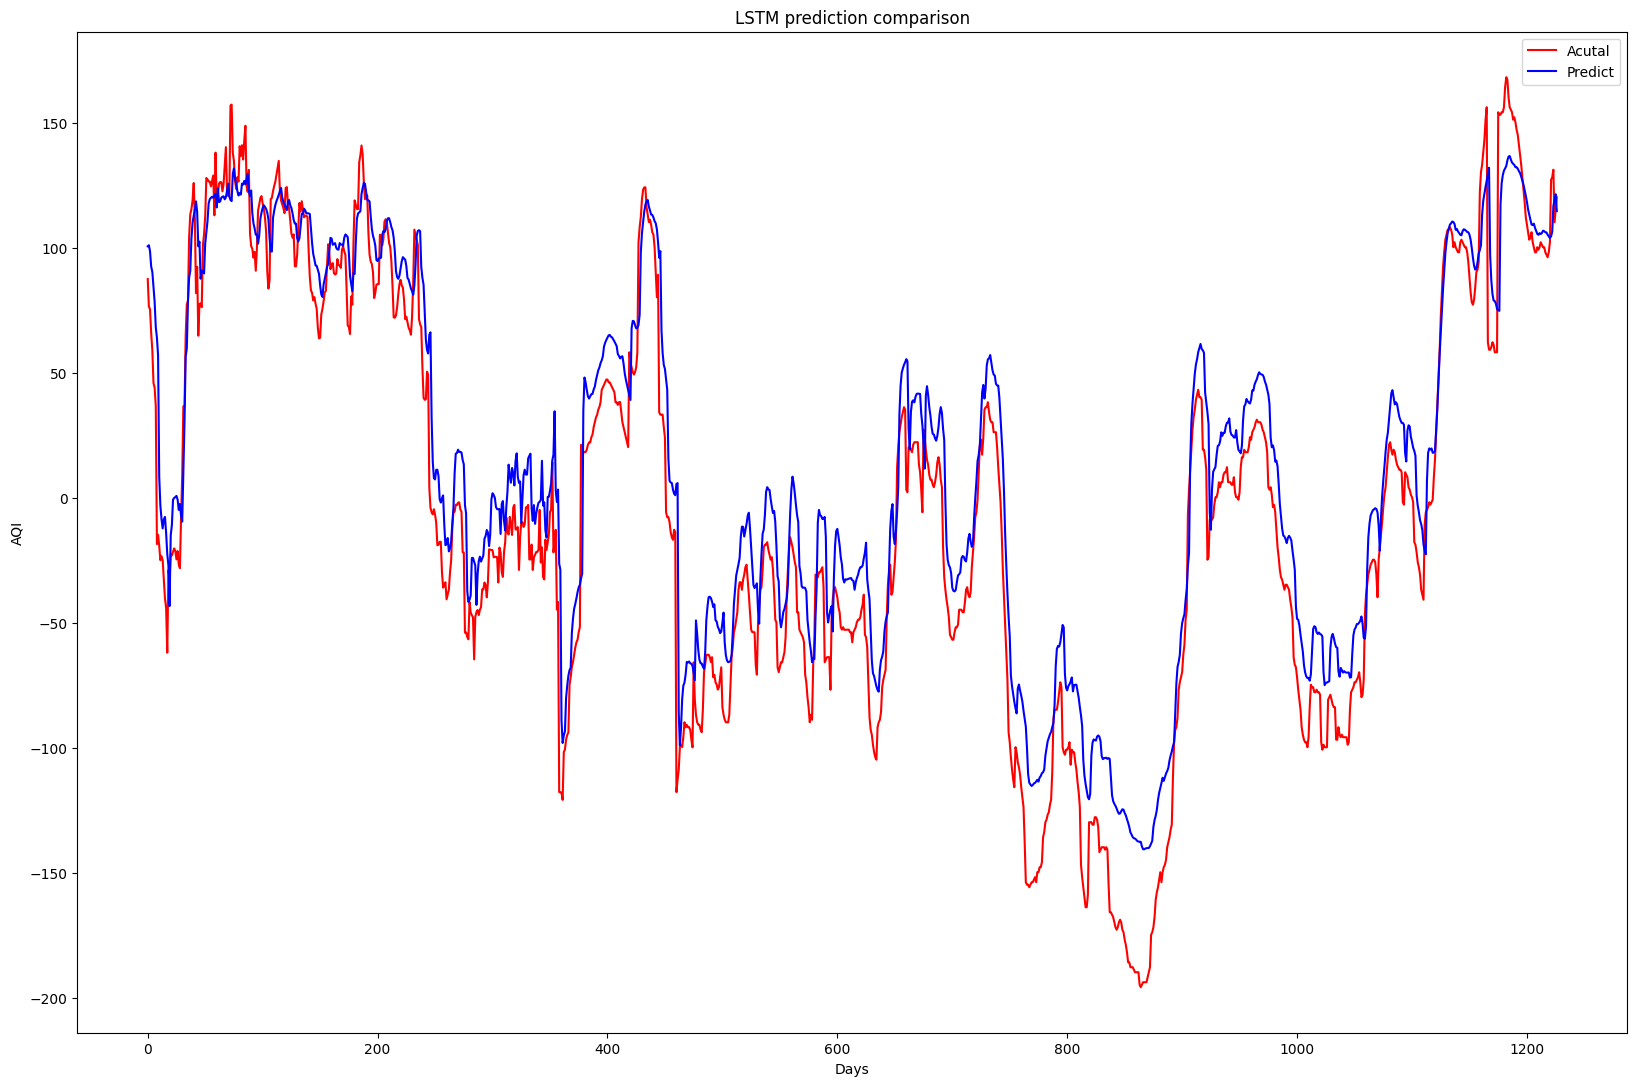

In [64]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset MSE: {MSE} RMSE:{RMSE}')

Training dataset RMSE:25.621740388403264


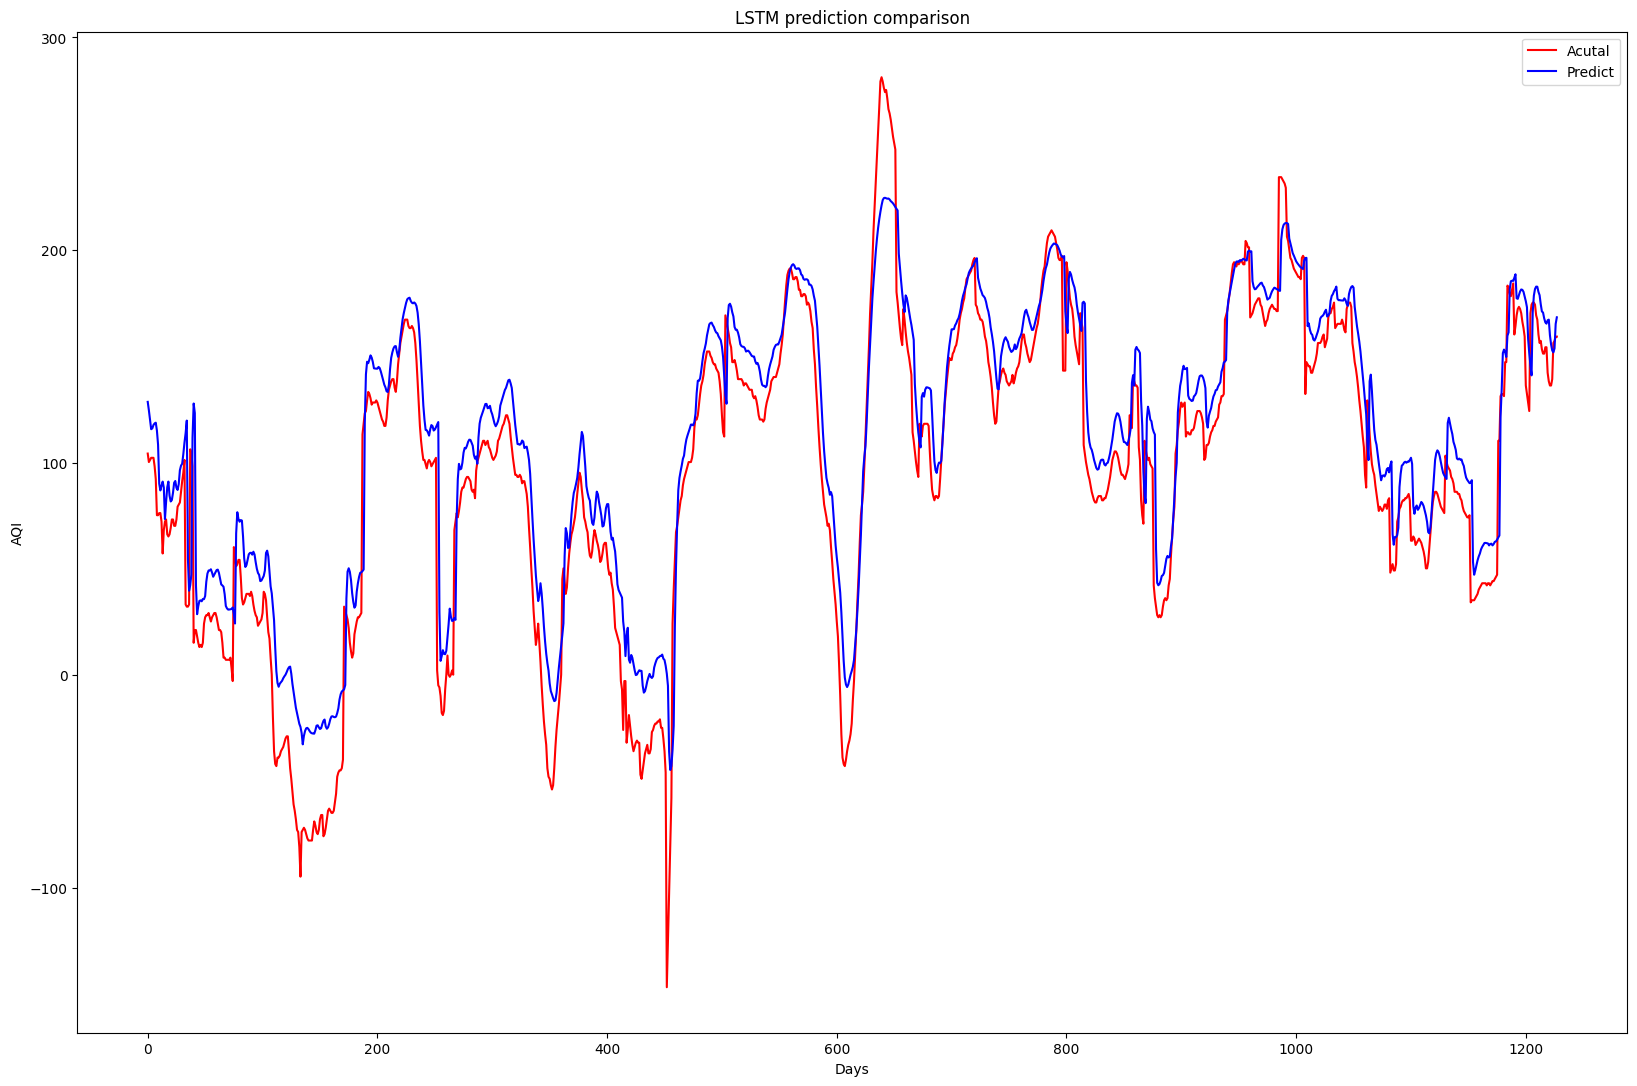

In [65]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('LSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [66]:
final_result= ARIMA_Result['predicted'][size+window_size:].values + y_test_pred.squeeze(1)

In [67]:
fr = ARIMA_Result[['predicted','raw']][size+window_size:].copy()
fr['final'] = final_result
fr

predicted    raw       final
Datetime                                          
2015-10-08 18:00:00  275.721324  384.0  404.307033
2015-10-08 19:00:00  275.721431  380.0  400.332270
2015-10-08 20:00:00  275.721800  376.0  395.931578
2015-10-08 21:00:00  275.722065  377.0  391.451122
2015-10-08 22:00:00  275.721965  378.0  391.859584
...                         ...    ...         ...
2015-12-31 19:00:00  275.721699  412.0  428.471729
2015-12-31 20:00:00  275.721699  415.0  427.601978
2015-12-31 21:00:00  275.721699  432.0  429.460942
2015-12-31 22:00:00  275.721699  433.0  440.966816
2015-12-31 23:00:00  275.721699  435.0  444.079746

[1228 rows x 3 columns]

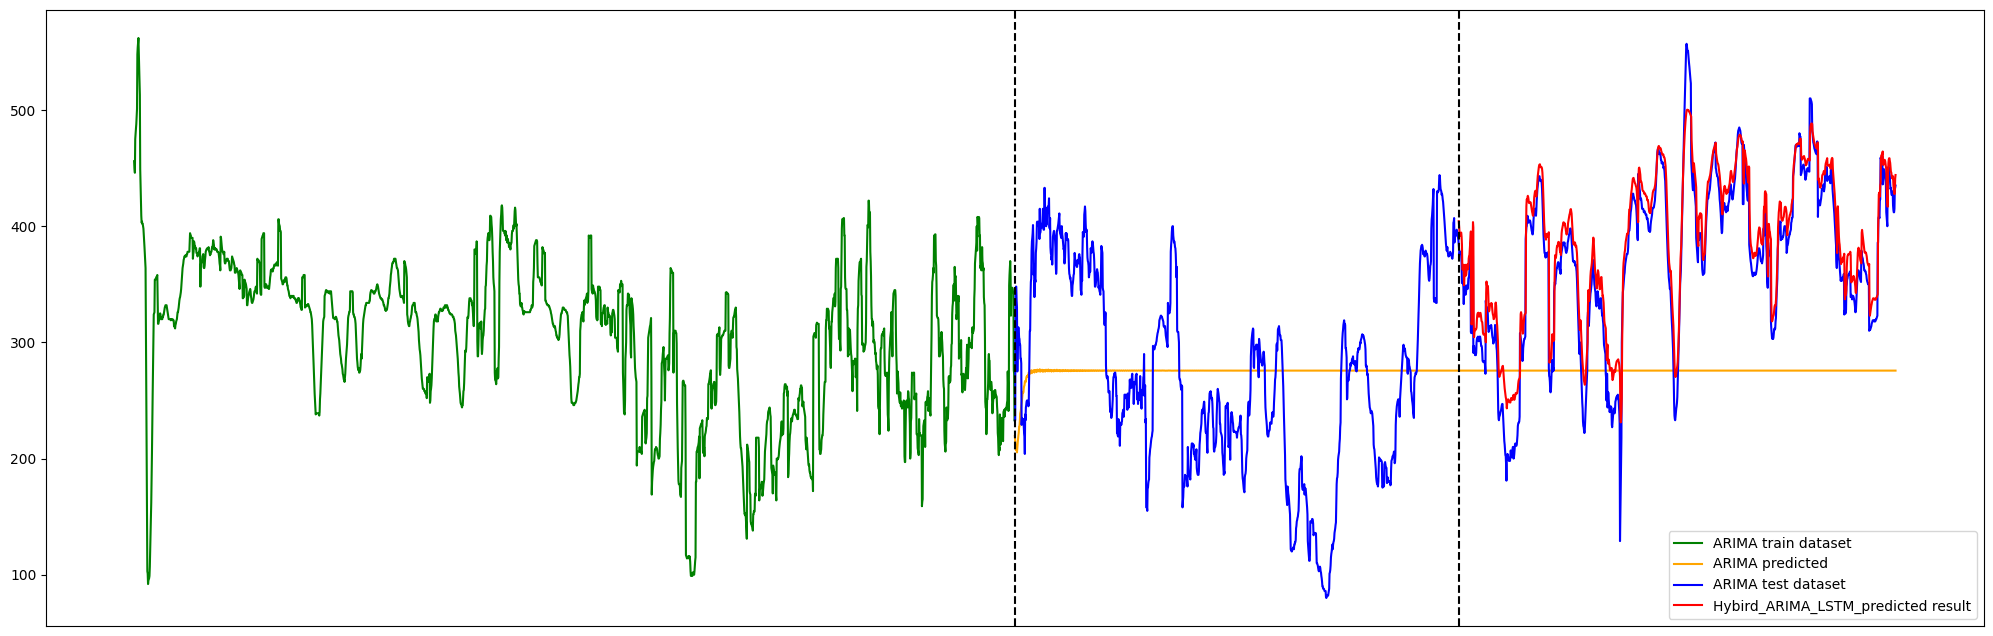

In [68]:
plt.figure(figsize=(25,8))
plt.plot(train_data['AQI'], label ='ARIMA train dataset', color='green')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted', color='orange')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset", color ='blue')
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result', color='red')
plt.axvline(x=len(train_data['AQI']), c='black', linestyle='--')
plt.axvline(x=len(train_data['AQI']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

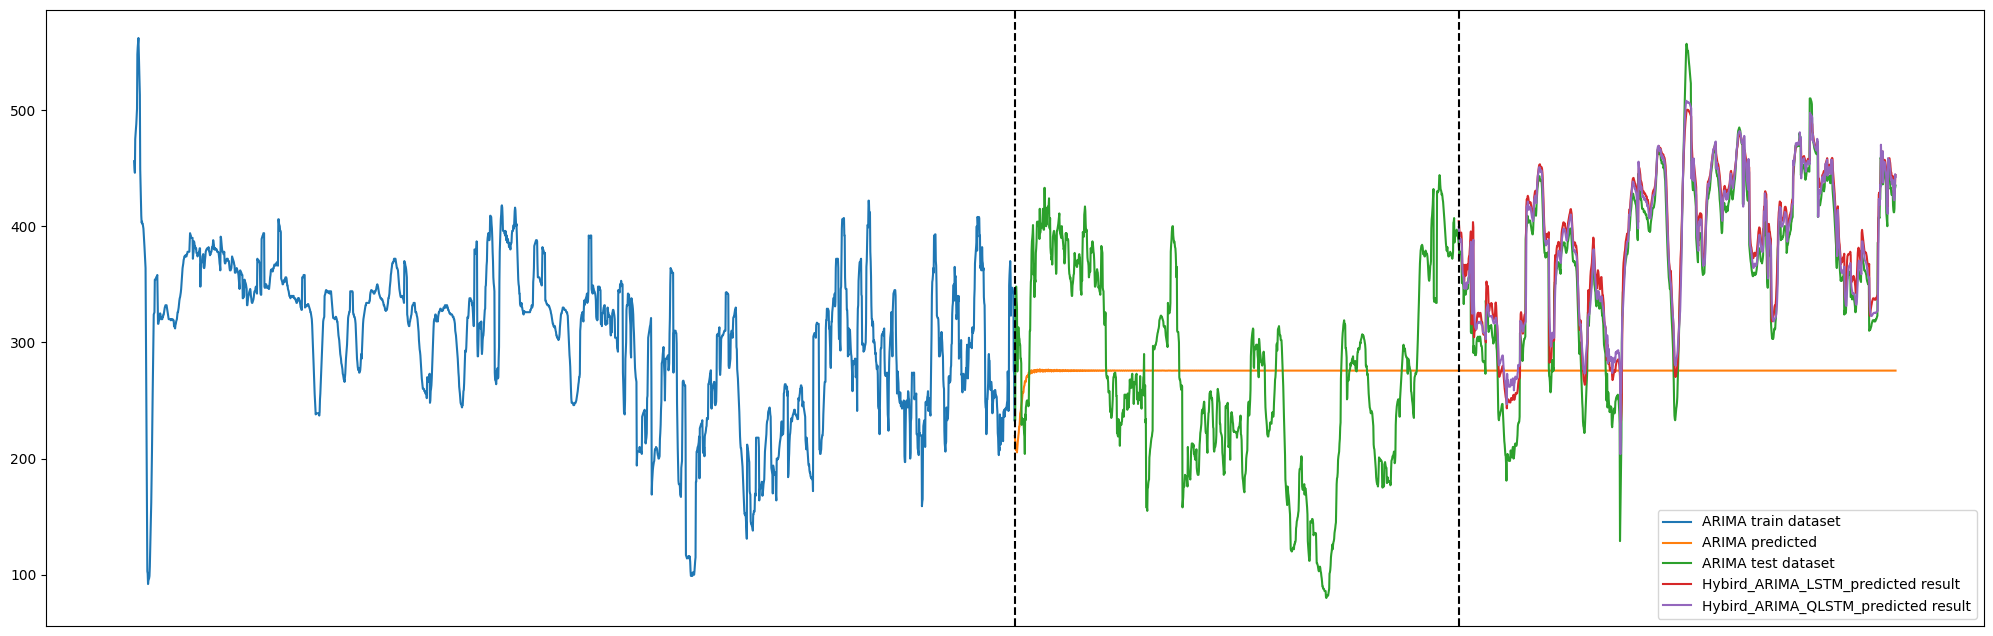

In [69]:
plt.figure(figsize=(25,8))
plt.plot(train_data['AQI'], label ='ARIMA train dataset')
plt.plot(ARIMA_Result['predicted'], label ='ARIMA predicted')
plt.plot(ARIMA_Result['raw'], label = "ARIMA test dataset")
plt.plot(fr['final'], label = 'Hybird_ARIMA_LSTM_predicted result')
plt.plot(frq['final'], label = 'Hybird_ARIMA_QLSTM_predicted result')
plt.axvline(x=len(train_data['AQI']), c='black', linestyle='--')
plt.axvline(x=len(train_data['AQI']) + len(ARIMA_Result['predicted']) - len(frq['final']), c='black', linestyle='--')
plt.gca().set_xticks([])
plt.plot()
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(final_result,ARIMA_Result['raw'][size+window_size:].values )    
mae = mean_absolute_error(final_result, ARIMA_Result['raw'][size+window_size:].values)
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 530.8342109250767
X_test MAE: 19.211769464185487
X_test RMSE: 23.039839646253547


In [71]:
torch.save(modelQ,'./SavedModels/Weather/Delhi_AQI/AQI/arima_lstm')

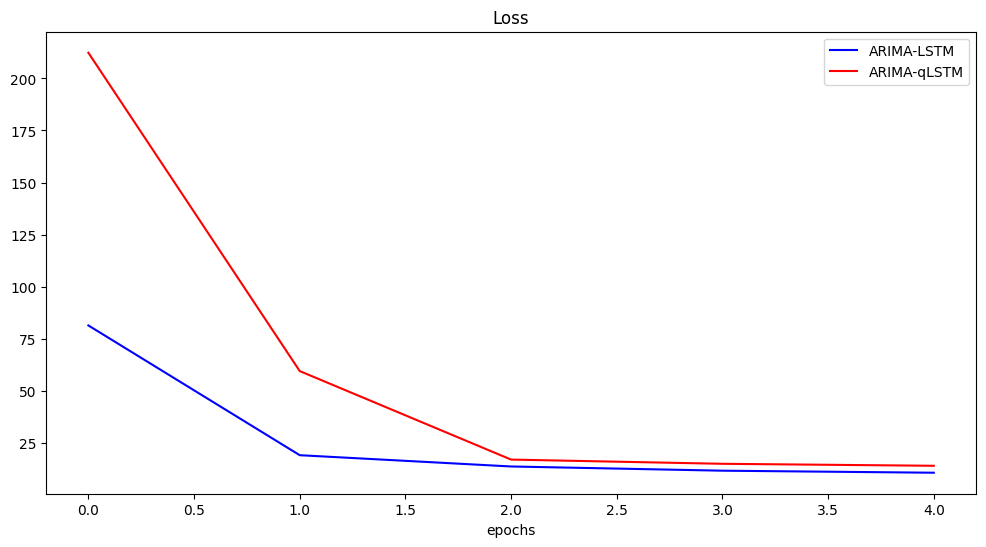

In [72]:
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'ARIMA-LSTM')
plt.plot(histQ1, color='red', label='ARIMA-qLSTM')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')